Matteo Picciolini

# Esercitazione 7

In [99]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import statsmodels.api as sm

#numpy
import numpy as np

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Exercise 07.1
In the MD/MC code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

### Risoluzione
Riprendo il codice dell'esercitazione 4 e correggo l'approssimazione relativa al raggio di cutoff. In tale esercitazione, infatti, si considera nulla l'interazione tra coppie di particelle con distanza maggiore a quella fissata dal raggio di cutoff. Naturalmente questa approssimazione è grossolana, ma c'è la possibiltà di tenere conto del contributo dell'interazione tra queste particelle attraverso le *tail corrections* di energia potenziale e pressione.

Si può dimostrare che per un potenziale di Lennard-Jones queste correzioni valgono rispettivamente:
$$
\frac{\langle U \rangle _{tail}}{N}   =8\pi\rho\epsilon \left[ \frac{1}{9 r_c^9} - \frac{1}{3 r_c^3} \right]
\qquad \qquad \frac{\langle W \rangle _{tail}}{3N\epsilon}   = 32\pi\rho        \left[            \frac{1}{9 r_c^9}           - \frac{1}{6 r_c^3}        \right]
$$
dove $\rho$ e $r_c$ sono espresse in unità nel sistema di Lennard Jones. Anche in questa esercitazione uso $\sigma=\epsilon = 1$.

Ho implementato queste correzioni nel codice dell'esercitazione 4, inserendo nella funzione `Input` queste due righe:

```c++
v_tail = (8 * M_PI * rho) * ((1 / (9 * pow(rcut, 9))) - (1 / (3 * pow(rcut, 3))));
w_tail = (32 * M_PI * rho) * ((1 / (9 * pow(rcut, 9))) - (1 / (6 * pow(rcut, 3))));
```
Dopodichè, ho sommato le *tail corrections* ai valori di pressione e energia potenziali calcolati instantaneamente.

## Exercise 07.2

Use the MD/MC code to print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

### Risoluzione
Per ottenere un *acceptance ratio* di circa il $50\%$, ho utilizzato le seguenti ampiezze di passo:
- fase solida: $\delta = 0.11$;
- fase liquida: $\delta = 0.2$;
- fase gassosa: $\delta = 5$.
#### Valori istantanei di $U/N$
Per la fase di equilibrazione sono bastati $10^4$ steps per tutte le fasi. Come richiesto, mostro ora i valori istantanei assunti dall'energia potenziale per una simulazione da $5 \times 10^5$ steps.

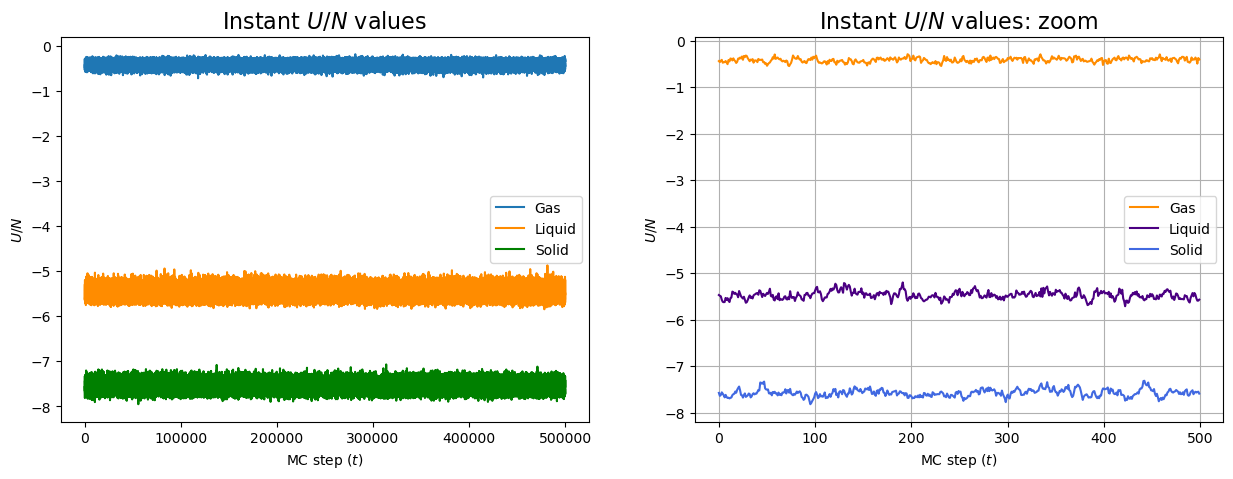

In [98]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

#Load Gas Data
gas_instant = np.loadtxt("../Data/07.1_MC_gas_1.20_instant_epot.dat")

#Load Liquid Data
liquid_instant = np.loadtxt("../Data/07.1_MC_liquid_1.10_instant_epot.dat")

#Load Solid Data
solid_instant = np.loadtxt("../Data/07.1_MC_solid_0.80_instant_epot.dat")

#plot
axs[0].plot(gas_instant, label = 'Gas')
axs[0].plot(liquid_instant, color = 'darkorange', label = 'Liquid')
axs[0].plot(solid_instant, color = 'green', label = 'Solid')

axs[0].set_ylabel('$U/N$')
axs[0].set_xlabel('MC step $(t)$')
axs[0].legend()
axs[0].set_title('Instant $U/N$ values', fontsize = 16) 

axs[1].plot(gas_instant[:500], color='darkorange', label='Gas')
axs[1].plot(liquid_instant[:500], color='indigo', label='Liquid')
axs[1].plot(solid_instant[:500], color='royalblue', label='Solid')

axs[1].set_ylabel('$U/N$')
axs[1].set_xlabel('MC step $(t)$')
axs[1].legend(loc='upper right')


axs[1].set_title('Instant $U/N$ values: zoom', fontsize = 16) 
axs[1].grid()
plt.show()

#### Calcolo dell'autocorrelazione
Per implementare efficacemente il data blocking, è necessario stimare il "tempo" di autocorrelazione $\tau$ (misurato in unità di step MC) e assicurarsi che il numero di step per blocco sia molto maggiore di $\tau$. Per fare ciò, utilizzo le $5\times 10^5$ estrazioni descritte nel paragrafo precedente per calcolarne l'autorrelazione.

In generale, l'autocorrelazione è uno strumento che definisce il grado di dipendenza tra i valori assunti da una funzione campionata nel suo dominio in ascissa. Essa misura, quindi, la correlazione tra i valori della funzione presi in punti diversi del dominio. L'autocorrelazione può essere utilizzata per valutare se i valori della funzione presentano una correlazione tra loro e se esistono pattern o ciclicità nel loro comportamento.

$$\text{Autocorrelation}(\text{lag}-k) = \frac{\sum\limits_{i=1}^{n-k} (x_i - \mu)(x_{i+k} - \mu)}{(n - k) \cdot \sigma^2}$$


tau Gas: 2.769347911585192
tau Liquid: 9.69194633216425
tau Solid: 8.377402675283454


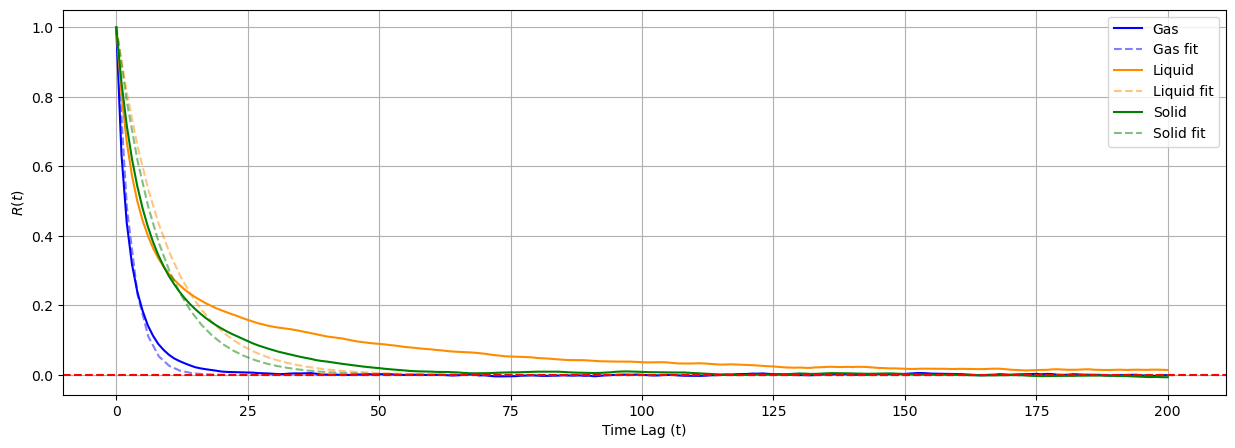

In [100]:
def exponential(x, a, b):
    return a * np.exp(-b * x)

def plot_autocorrelation(data, label, color):
    max_lag = 200
    
    # Calcolo dell'autocorrelazione
    acorr = sm.tsa.acf(data, nlags = max_lag)

    # Fitting esponenziale
    x = np.arange(len(acorr))
    popt, pcov = curve_fit(exponential, x, acorr, bounds = ([1, 0], [np.inf, np.inf]))
    a_fit, b_fit = popt

    # Calcolo di tau
    tau = 1 / b_fit
    print('tau {}: {}'.format(label, tau))

    # Generazione punti per la curva di fit
    x_fit = np.linspace(0, len(acorr), 100)
    y_fit = exponential(x_fit, a_fit, b_fit)

    # Creazione del grafico
    
    plt.plot(x, acorr, label = label, c = color)
    plt.plot(x_fit, y_fit, label = label + ' fit', c = color, ls = '--', alpha = 0.5)
    

plt.figure(figsize = (15, 5))

# Plot dell'autocorrelazione per i dati del gas
plot_autocorrelation(gas_instant, 'Gas', 'blue')
plot_autocorrelation(liquid_instant, 'Liquid', 'darkorange')
plot_autocorrelation(solid_instant, 'Solid', 'green')

plt.axhline(0, ls = '--', color = 'red')
plt.ylabel('$R(t)$')
plt.xlabel('Time Lag (t)')
plt.grid()
plt.legend()
plt.show()


Gas completed
Liquid completed
Solid completed


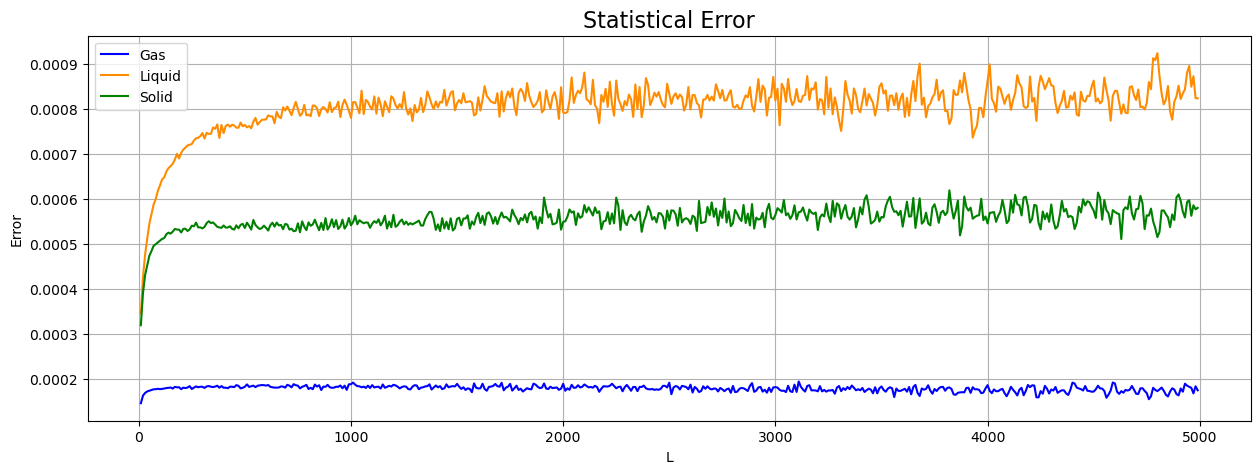

In [101]:
def calculate_error(average, average_squared, n):
    # Calcola l'errore a partire dalla media, la media al quadrato e il numero di campioni.
    if n == 0:
        return 0
    return np.sqrt((average_squared - average ** 2) / n)

def data_blocking_analysis(data, num_blocks, block_length):
    # Esegue l'analisi di data blocking su un insieme di dati.
    running_average = 0
    running_average_squared = 0
    error = 0

    for block_index in range(num_blocks):
        block_sum = 0

        for data_index in range(block_length):
            block_sum += data[data_index + block_index * block_length]

        block_mean = block_sum / block_length

        running_average = (running_average * block_index + block_mean) / (block_index + 1)
        running_average_squared = (running_average_squared * block_index + block_mean**2) / (block_index + 1)
        error = calculate_error(running_average, running_average_squared, block_index)

    return error


def plot_statistical_error(data, title, color):
    errors = []
    x_values = []
    L_range = range(L_min, L_max, 10)
    for L in L_range:
        N = int(M / L)
        err = data_blocking_analysis(data, N, L)
        errors.append(err)
        x_values.append(L)

    plt.plot(x_values, errors, label = title, color = color)
    
L_min = 10
L_max = 5000
M = 500000

fig = plt.figure(figsize = (15, 5))

plt.title("Statistical Error", fontsize = 16)

plot_statistical_error(gas_instant, 'Gas', 'blue')
print("Gas completed")
plot_statistical_error(liquid_instant, 'Liquid', 'darkorange')
print("Liquid completed")
plot_statistical_error(solid_instant, 'Solid', 'green')
print("Solid completed")

plt.legend()
plt.ylabel("Error")
plt.xlabel('L')
plt.grid(True)
plt.show()

## Exercise 07.3

Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the MD/MC code: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.

### Risoluzione
A partire dai risultuati della sezione precedente, scelgo di impostare le simulazioni con $50$ blocchi da $2000$ passi.

Come richiesto, implemento nel codice il calcolo della funzione di distribuzione radiale $g(r)$ nell'intervallo $r \in \left[ 0; L/2\right]$, dove $r$ è la distanza tra coppie di particelle. La funzione di distribuzione radiale descrive la probabilità di trovare una particella a distanza $r$ da una particella di riferimento. La $g(r)$ si calcola come segue:
$$
g(r) =\frac{1}{\rho N\Delta V(r)} 
    \left\langle \sum_{i=1}^N \sum_{j=1,\neq i}^N \delta(r-|\vec r_i-\vec r_j |) \right\rangle
$$
dove $\Delta V(r) = \frac{4\pi}{3}\left[(r+dr)^3-r^3\right]$ è il volume di un guscio sferico in cui viene cercata la particella.

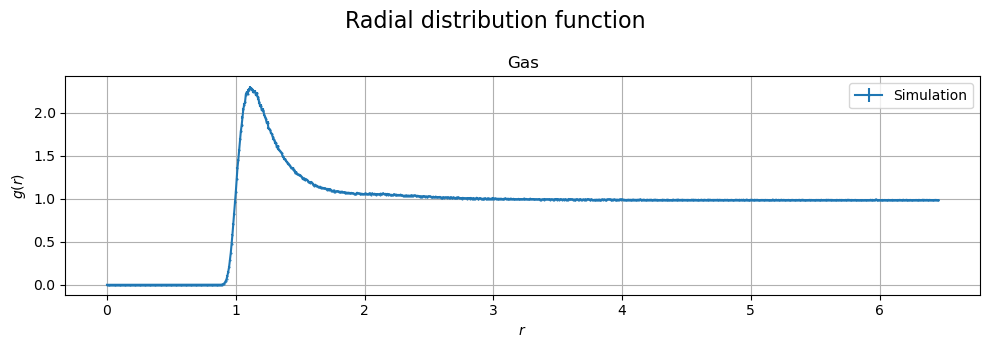

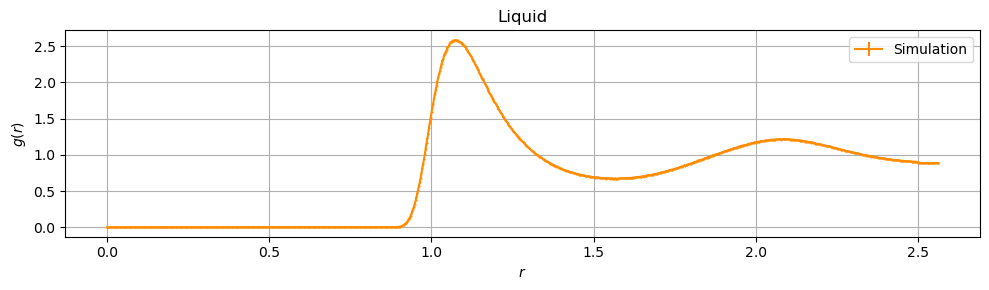

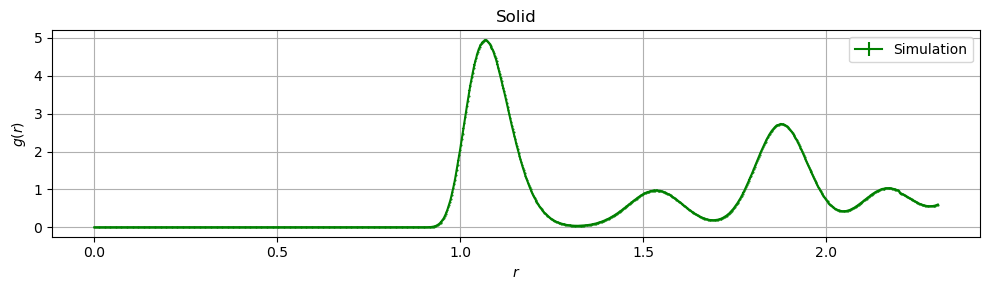

In [178]:
#GAS
plt.figure(figsize = (10,3.5))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_gas_1.20_finalGr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o', 
             markersize = 0.5, label = 'Simulation')
plt.title('Gas')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.suptitle('Radial distribution function', fontsize = 16)
plt.tight_layout()
plt.show()


#LIQUID
plt.figure(figsize = (10,3))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_liquid_1.10_finalGr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o', 
             markersize = 0.5, label = 'Simulation', color = 'darkorange')
plt.title('Liquid')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#SOLID
plt.figure(figsize = (10,3))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_solid_0.80_finalGr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o', 
             markersize = 0.5, label = 'Simulation', color = 'green')
plt.title('Solid')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Exercise 07.4

By means of your upgraded MD/MC code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units ... and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

### Risoluzione

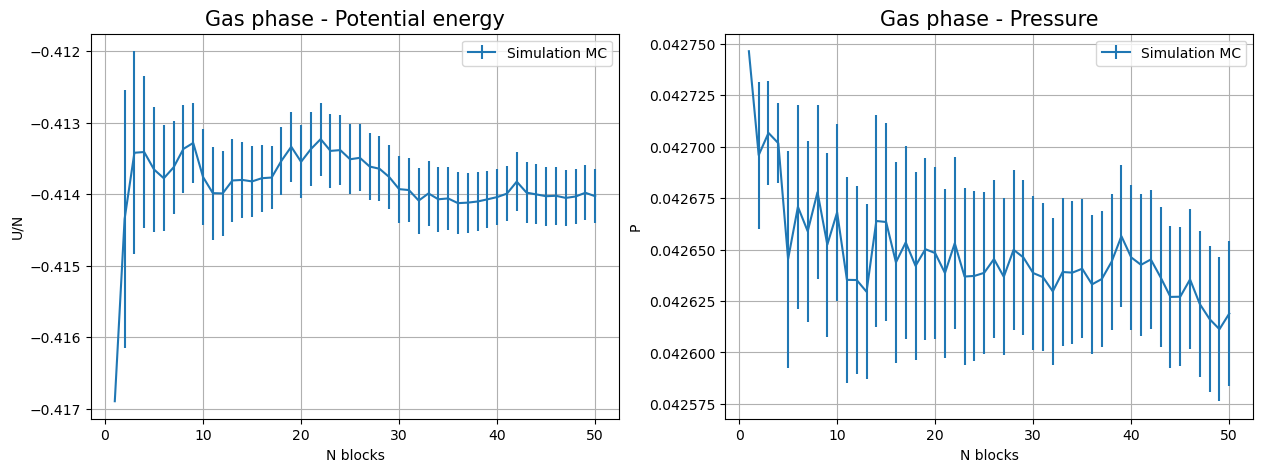

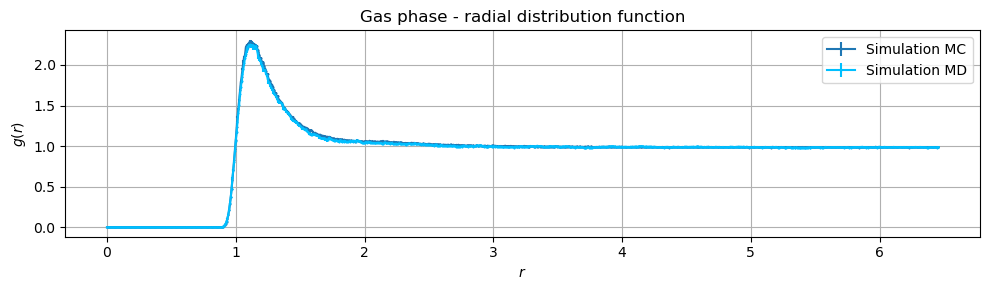

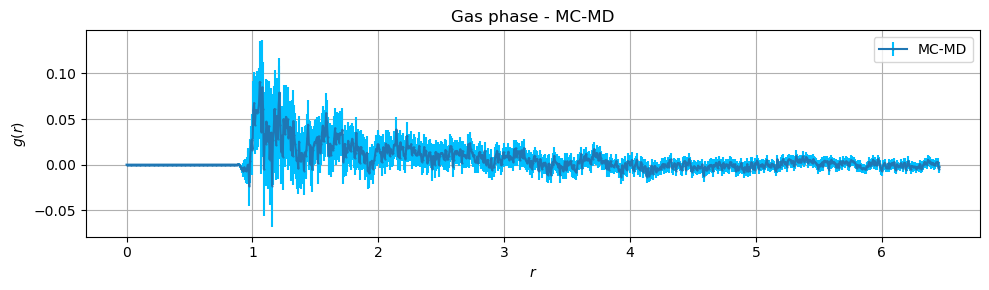

In [173]:
#GAS
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
#plot 1
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_gas_1.20_epot.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC")
axs[0].set_xlabel('N blocks')
axs[0].set_ylabel('U/N')
axs[0].grid(True)
axs[0].set_title('Gas phase - Potential energy', fontsize = 15)
axs[0].legend()

#plot 2
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_gas_1.20_press.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[1].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC")
axs[1].set_ylabel('P')
axs[1].set_xlabel('N blocks')
axs[1].set_title('Gas phase - Pressure', fontsize = 15)
axs[1].legend()
axs[1].grid(True)

plt.show()

#GAS - MD vs MC
plt.figure(figsize = (10,3))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_gas_1.20_finalGr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o',
             markersize = 0.5, label = 'Simulation MC')
x_label_md, progressive_sum_md, progressive_error_md = np.loadtxt('../Data/07.1_MD_gas_1.20_finalGr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label_md, progressive_sum_md, yerr = progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'Simulation MD', color = 'deepskyblue')
plt.title('Gas phase - radial distribution function')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

####
plt.figure(figsize = (10,3))

plt.errorbar(x_label, progressive_sum - progressive_sum_md, 
             yerr = progressive_error + progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'MC-MD', ecolor = 'deepskyblue')
plt.title('Gas phase - MC-MD')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

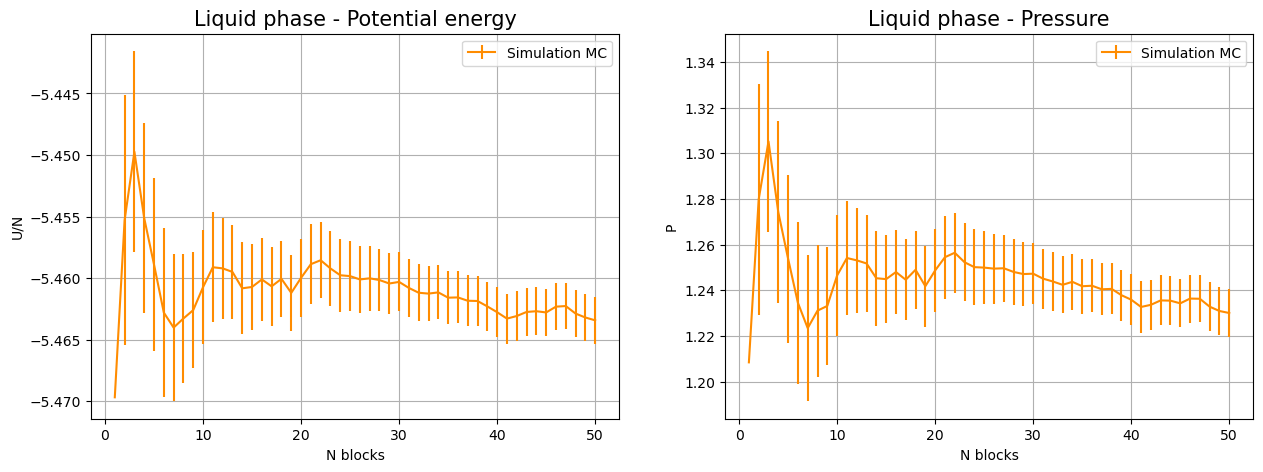

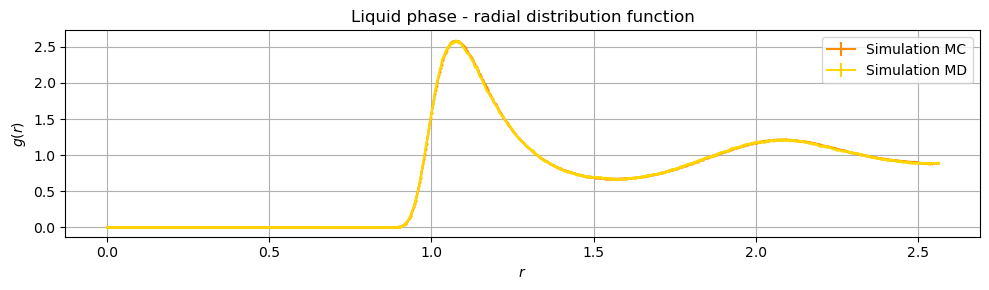

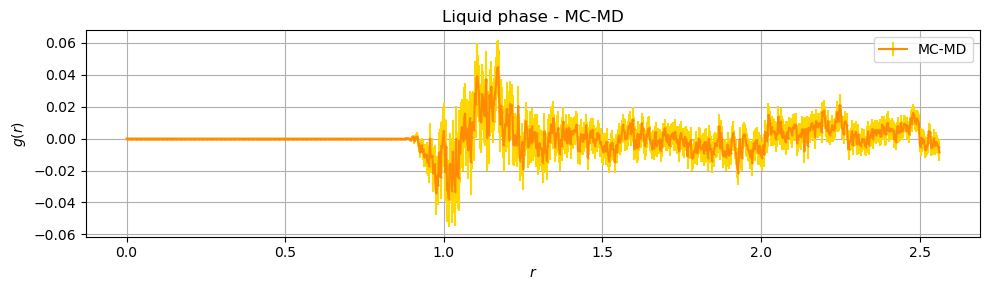

In [175]:
#LIQUID
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
#plot 1
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_liquid_1.10_epot.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC", color = 'darkorange')
axs[0].set_xlabel('N blocks')
axs[0].set_ylabel('U/N')
axs[0].grid(True)
axs[0].set_title('Liquid phase - Potential energy', fontsize = 15)
axs[0].legend()

#plot 2
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_liquid_1.10_press.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[1].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC", color = 'darkorange')
axs[1].set_ylabel('P')
axs[1].set_xlabel('N blocks')
axs[1].set_title('Liquid phase - Pressure', fontsize = 15)
axs[1].legend()
axs[1].grid(True)

plt.show()


#LIQUID - MD vs MC
plt.figure(figsize = (10,3))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_liquid_1.10_finalGr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o',
             markersize = 0.5, label = 'Simulation MC', color = 'darkorange')
x_label_md, progressive_sum_md, progressive_error_md = np.loadtxt('../Data/07.1_MD_liquid_1.10_finalGr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label_md, progressive_sum_md, yerr = progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'Simulation MD', color = 'gold')
plt.title('Liquid phase - radial distribution function')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

####
plt.figure(figsize = (10,3))

plt.errorbar(x_label, progressive_sum - progressive_sum_md, 
             yerr = progressive_error + progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'MC-MD', color = 'darkorange', ecolor = 'gold')
plt.title('Liquid phase - MC-MD')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

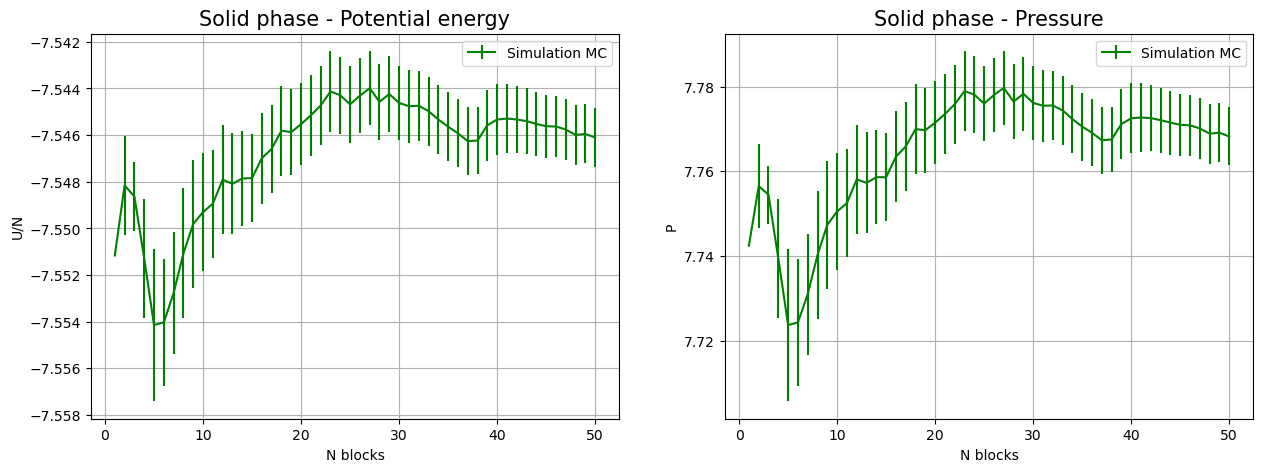

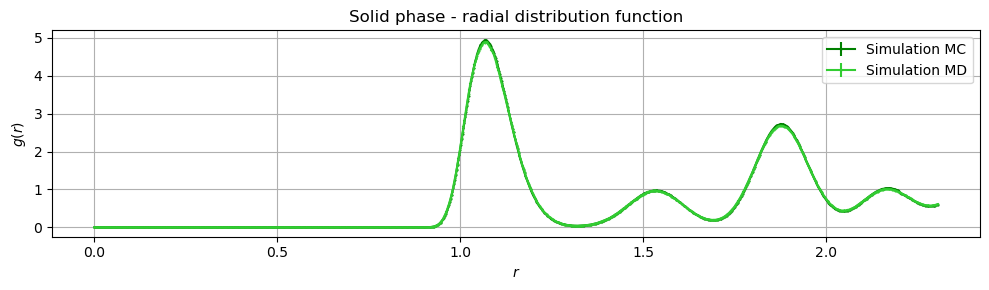

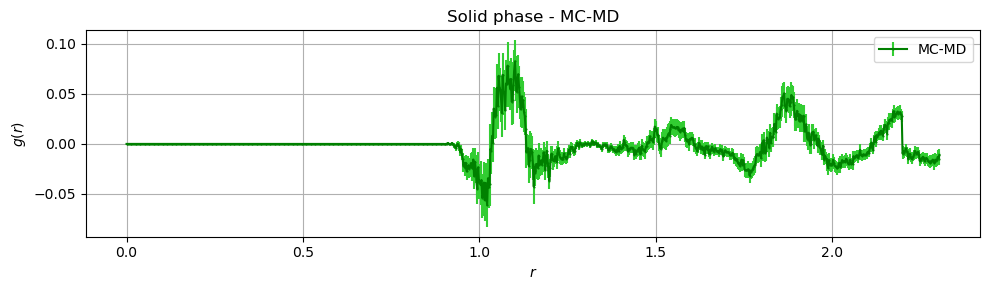

In [172]:
#SOLID
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
#plot 1
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_solid_0.80_epot.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[0].errorbar(x_label, progressive_sum, yerr = progressive_error, 
                label = "Simulation MC", color = 'green')
axs[0].set_xlabel('N blocks')
axs[0].set_ylabel('U/N')
axs[0].grid(True)
axs[0].set_title('Solid phase - Potential energy', fontsize = 15)
axs[0].legend()

#plot 2
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_solid_0.80_press.dat',
                                                          unpack = True, usecols = (0, 2, 3))
axs[1].errorbar(x_label, progressive_sum, yerr = progressive_error, label = "Simulation MC", color = 'green')
axs[1].set_ylabel('P')
axs[1].set_xlabel('N blocks')
axs[1].set_title('Solid phase - Pressure', fontsize = 15)
axs[1].legend()
axs[1].grid(True)

plt.show()

#SOLID - MD vs MC
plt.figure(figsize = (10,3))
x_label, progressive_sum, progressive_error = np.loadtxt('../Data/07.1_MC_solid_0.80_finalGr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label, progressive_sum, yerr = progressive_error, marker = 'o',
             markersize = 0.5, label = 'Simulation MC', color = 'green')
x_label_md, progressive_sum_md, progressive_error_md = np.loadtxt('../Data/07.1_MD_solid_0.80_finalGr.dat',
                                                         unpack = True, usecols = (0, 1, 2)) 
plt.errorbar(x_label_md, progressive_sum_md, yerr = progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'Simulation MD', color = 'limegreen')
plt.title('Solid phase - radial distribution function')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

####
plt.figure(figsize = (10,3))

plt.errorbar(x_label, progressive_sum - progressive_sum_md, 
             yerr = progressive_error + progressive_error_md, marker = 'o',
             markersize = 0.5, label = 'MC-MD', color = 'green', ecolor = 'limegreen')
plt.title('Solid phase - MC-MD')
plt.ylabel('$g(r)$')
plt.xlabel('$r$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()